In [1]:
#importing all the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from fbprophet import Prophet

In [2]:
##reading the data and preprocessing
def read():

	file_channels = 'case_jr_analyst/orders_channels.csv'
	file_country = 'case_jr_analyst/orders_country.csv'
	file_tickets = 'case_jr_analyst/orders_tickets.csv'

	df_channels= pd.read_csv(file_channels)
	df_country = pd.read_csv(file_country)
	df_tickets = pd.read_csv(file_tickets)

	return df_channels, df_country, df_tickets

def preprocess(df1, df2):

	df_channels = df1.dropna()
	df_channels_cleaned = df_channels.drop_duplicates(keep='first')

	df_country_cleaned = df2
	df_country_cleaned.loc[df_country_cleaned['country_1'].isnull(),'country_1'] = df_country_cleaned['country_2']
	df_country_cleaned = df_country_cleaned[pd.notnull(df_country_cleaned['country_1'])]
	df_country_cleaned.drop(['country_2'], axis=1,inplace=True)

	return df_channels_cleaned, df_country_cleaned

In [3]:
## use the functions and get all the data with formatted date 
data = read()

df_channels = data[0]
df_country = data[1]
df_tickets = data[2]




clean_data = preprocess(df_channels, df_country)


df_tickets.drop(['type'], axis=1, inplace=True)
df_tickets_cleaned = df_tickets.groupby('id',sort=False).sum().reset_index()


df_channels_cleaned = clean_data[0]

df_country_cleaned = clean_data[1]
df_country_cleaned = df_country_cleaned[~df_country_cleaned['country_1'].isin(['xx'])]



dfs = [df_channels_cleaned, df_tickets_cleaned, df_country_cleaned]
df_final = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
df_final_sortedbydate = df_final.sort_values(by='date') # dont delete

df_final_sortedbydate['date'] = pd.to_datetime(df_final_sortedbydate['date'])
df_final_sortedbydate['date_delta'] = (df_final_sortedbydate['date'] - df_final_sortedbydate['date'].min())  / np.timedelta64(1,'D')


X = df_final_sortedbydate[['channel_id', 'country_1']]

y = df_final_sortedbydate['n_tickets']

/Users/deepakmishra/Desktop/Project/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
## get only the required datafields
df_final = df_final_sortedbydate[['channel_id', 'country_1', 'n_tickets','date']]

In [71]:
#checking for unique case of channel id
df_final = df_final.loc[df_final['channel_id'] == 39.0, ]

In [72]:
#checking for unique case of country
df_final = df_final.loc[df_final['country_1'] == 24, ]

In [73]:
## checking for if 
df_final = df_final.drop('country_1', 1)
df_final = df_final.drop('channel_id', 1)

In [74]:
df_final.dtypes

n_tickets             int64
date         datetime64[ns]
dtype: object

In [100]:
## get the data to check for sum of all tickets on unique dates
df = pd.DataFrame()
df['ds'] = df_final.date.unique()
x = df_final.groupby(['date']).sum()
x = x.reset_index(drop=True)
df = df.reset_index(drop=True)
df['y'] = x['n_tickets']

In [113]:
## final date
df['ds'].max()

Timestamp('2018-02-26 00:00:00')

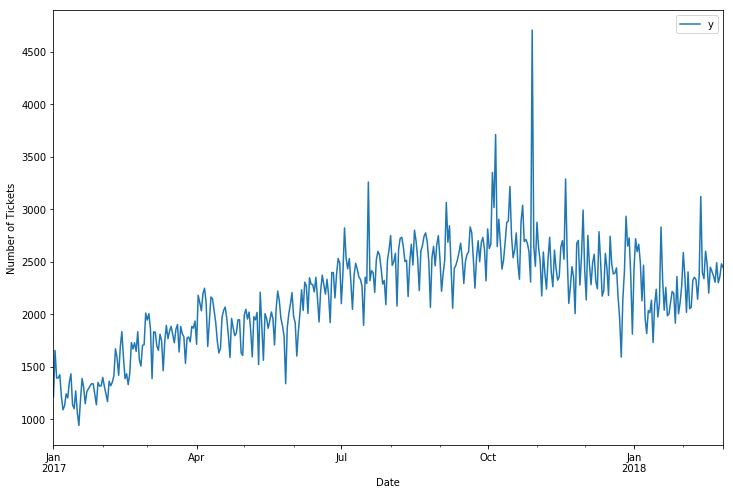

In [102]:
## plotting date to number of tickets for checking the time series pattern
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Number of Tickets')
ax.set_xlabel('Date')

plt.show()

In [103]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [104]:
##fit the model
my_model.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
## take the next 10 days for prediction
future_dates = my_model.make_future_dataframe(periods=10)
future_dates.tail(10)

ds
422 2018-02-27
423 2018-02-28
424 2018-03-01
425 2018-03-02
426 2018-03-03
427 2018-03-04
428 2018-03-05
429 2018-03-06
430 2018-03-07
431 2018-03-08

In [111]:
##forecast the model with lower and upper bound of number of tickets
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds         yhat   yhat_lower   yhat_upper
422 2018-02-27  2192.427182  1764.669381  2638.010871
423 2018-02-28  2229.285435  1737.914969  2655.423746
424 2018-03-01  2304.645409  1862.749834  2764.120335
425 2018-03-02  2181.701461  1756.860250  2636.488230
426 2018-03-03  1915.434225  1485.068092  2357.172375
427 2018-03-04  2252.092361  1814.569393  2673.954890
428 2018-03-05  2233.176593  1785.058659  2643.777558
429 2018-03-06  2168.837920  1704.727448  2596.280842
430 2018-03-07  2205.696173  1755.578908  2614.092385
431 2018-03-08  2281.056147  1826.063550  2741.578664

## next steps and tasks 
1. take all the unique combination of country id and channel id and perform the above task
2. functionalize the code later for deployment
3. make the cut off for 10 days before to check the accuracy of the time series forecasting model